In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import networkx as nx
from scipy.stats import pearsonr

# machine lerning
from sklearn.model_selection import cross_validate
from sklearn.ensemble import GradientBoostingRegressor

# Genre Importance Analysis

In [108]:
# Load data
df = pd.read_csv('../Data/preprocessed_data/final_data/full_db.csv')

columns_to_keep = ['name', 'main_genre_0','n_genres_0','main_genre_1','n_genres_1','main_genre_2','n_genres_2','success']
df = df[columns_to_keep]

In [109]:
# sample of main genre estimation for Early-, Mid- and Late-Career
df[df["name"] == "Nicolas Cage"]

,name,main_genre_0,n_genres_0,main_genre_1,n_genres_1,main_genre_2,n_genres_2,success
5185,Nicolas Cage,Drama,12.0,Drama,17.0,Action,17.0,2.25245


In [110]:
# find top-10 most frequent genres
genres_counts = df['main_genre_0'].value_counts()
frequent_genres = genres_counts .index.values.tolist()[:10]
print(frequent_genres)

['Drama', 'Comedy', 'TV Movie', 'Thriller', 'Action', 'Horror', 'Music', 'Family', 'Romance', 'Documentary']


(0.6, 1.1)

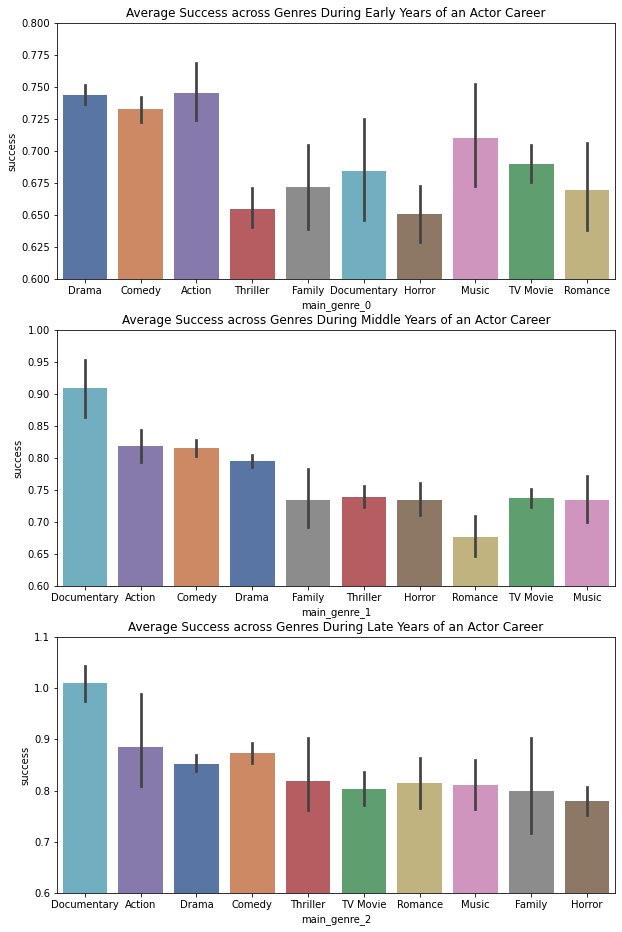

In [111]:
fig1, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 16))

ten_colors = sns.color_palette("deep", 10)
# combine each genre with its color, to avoid ordering issues
colors= dict(zip(frequent_genres, ten_colors))

sns.barplot(x="main_genre_0", y="success", data=df.loc[df['main_genre_0'].isin(frequent_genres)], ax=axes[0], palette=colors)
axes[0].set_title("Average Success across Genres During Early Years of an Actor Career")
axes[0].set_ylim([0.6, 0.8])
sns.barplot(x="main_genre_1", y="success", data=df.loc[df['main_genre_1'].isin(frequent_genres)], ax=axes[1], palette=colors)
axes[1].set_title("Average Success across Genres During Middle Years of an Actor Career")
axes[1].set_ylim([0.6, 1.0])
sns.barplot(x="main_genre_2", y="success", data=df.loc[df['main_genre_2'].isin(frequent_genres)], ax=axes[2], palette=colors)
axes[2].set_title("Average Success across Genres During Late Years of an Actor Career")
axes[2].set_ylim([0.6, 1.1])

## Regression Analysis: Gradient Boosting Regression

We apply one-hot encoding to categorical genre columns and fit models based on the encoded prevalent genre per period and diversity of genres

In [112]:
from sklearn.preprocessing import OneHotEncoder

In [113]:
# We start with the prevalent genre for Early-Career period
# one-hot-encoding for genres 
genre_early_years = pd.get_dummies(df["main_genre_0"])
X_1= genre_early_years
y_1= df['success']
model1= GradientBoostingRegressor()
results_model1 = cross_validate(model1, X_1, y_1, cv=3, scoring=('r2', 'neg_mean_squared_error'))
genre_early_years["n_genres"] = df["n_genres_0"]
X_2= genre_early_years # prediction based on the most frequent genre and diversity of genres
y_2= df['success']
model2= GradientBoostingRegressor()
results_model2 = cross_validate(model2, X_2, y_2, cv=3, scoring=('r2', 'neg_mean_squared_error'))

In [114]:
print("Prediction without diversity of genres - early years: r2 score ", round(results_model1["test_r2"].max(), 3))
print("Prediction with diversity of genres - early years: r2 score ", round(results_model2["test_r2"].max(), 3))

print("Prediction without diversity of genres - early years: neg MSE", round(results_model1["test_neg_mean_squared_error"].max(), 3))
print("Prediction with diversity of genres - early years: neg MSE", round(results_model2["test_neg_mean_squared_error"].max(), 3))

Prediction without diversity of genres - early years: r2 score  -0.186
Prediction with diversity of genres - early years: r2 score  -0.071
Prediction without diversity of genres - early years: neg MSE -0.024
Prediction with diversity of genres - early years: neg MSE -0.022


Diversity of genres almost doesn't influence the quality of prediction, probably, because multiple genres are assigned to each movie in tmdB database and as the result, diversity of genres for each actor is high. For the next experiments we do not consider that feature

In [115]:
# We continue for Middle-Career period
df = df.dropna(subset=['main_genre_1']) # Remove actors who don't have film in Phase 2 of career (ie keep group 2 and 3)
genre_mid_years= pd.get_dummies(df["main_genre_1"]) # ignore the Early-Career genre
X_1= genre_mid_years
y_1= df['success']
model1= GradientBoostingRegressor()
results_model1 = cross_validate(model1, X_1, y_1, cv=3, scoring=('r2', 'neg_mean_squared_error'))
genre_early_years= pd.get_dummies(df["main_genre_0"]) 
genre_early_mid_years = pd.concat([genre_early_years, genre_mid_years], axis=1) #add Early-Career genre
X_2= genre_early_mid_years
y_2= df['success']
model2= GradientBoostingRegressor()
results_model1 = cross_validate(model2, X_2, y_2, cv=3, scoring=('r2', 'neg_mean_squared_error'))

In [116]:
print("Prediction without early years - middle years: r2 score", round(results_model1["test_r2"].max(), 3))
print("Prediction with early years - middle years: r2 score", round(results_model2["test_r2"].max(), 3))

print("Prediction without early years - middle years: neg MSE", round(results_model1["test_neg_mean_squared_error"].max(), 3))
print("Prediction with early years - middle years: neg MSE", round(results_model2["test_neg_mean_squared_error"].max(), 3))

Prediction without early years - middle years: r2 score -0.112
Prediction with early years - middle years: r2 score -0.071
Prediction without early years - middle years: neg MSE -0.045
Prediction with early years - middle years: neg MSE -0.022


Negative value of the best R2 score across validation folds demonstrates that the most frequent genre during an actor's career doesn't really matter. But also we can investigate the dynamics of genre choices throughout their career. Let's find out what is more beneficial: switching between genres or sticking to a specific genre?

In [118]:
# for this part of analysis we only consider the actors who have the full career path from Early to Late career
df = df.dropna(subset=['main_genre_2']) # Remove actors who don't have film in Phase 3 of career

In [119]:
# actors who stick to one main genre during all career phases
df["single_genre"] = ((df["main_genre_0"] == df["main_genre_1"]) & (df["main_genre_0"] == df["main_genre_2"])).astype(int)
# actors who changes the main genre each career phase
df["diverse_genre"] = ((df["main_genre_0"] != df["main_genre_1"]) & (df["main_genre_0"] != df["main_genre_2"]) & \
                        (df["main_genre_1"] != df["main_genre_2"])).astype(int)
# the rest of actors have a preferred genre for 2/3 career phases
df["preferred_genre"] = 1 - df["single_genre"] - df["diverse_genre"]
df.head()

,name,main_genre_0,n_genres_0,main_genre_1,n_genres_1,main_genre_2,n_genres_2,success,single_genre,diverse_genre,preferred_genre
5163,Jim Carrey,Comedy,15.0,Comedy,16.0,Documentary,15.0,1.583744,0,0,1
5164,Morgan Freeman,Drama,10.0,Drama,15.0,Documentary,19.0,1.901150,0,0,1
5165,Denzel Washington,Drama,13.0,Drama,15.0,Documentary,12.0,2.020648,0,0,1
5166,Whoopi Goldberg,Comedy,17.0,Comedy,16.0,Documentary,16.0,1.603294,0,0,1
5167,Marilyn Monroe,Comedy,12.0,Documentary,6.0,Documentary,5.0,1.266968,0,0,1


In [120]:
print("Number of actors who stick to one main genre during all career phases: ", df["single_genre"].sum())
print("Number of actors who change the main genre each career phase: ", df["diverse_genre"].sum())
print("Number of actors who have changed the main genre once in career: ", df["preferred_genre"].sum())

Number of actors who stick to one main genre during all career phases:  478
Number of actors who change the main genre each career phase:  284
Number of actors who have changed the main genre once in career:  746


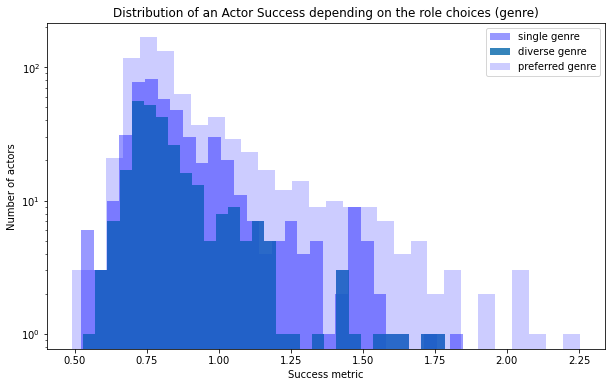

In [121]:
plt.figure(figsize=(10, 6))

plt.hist(df["success"].where(df["single_genre"] == 1), bins=30, color='b', alpha=0.4, label='single genre')
plt.hist(df["success"].where(df["diverse_genre"] == 1), bins=30, alpha=0.9, label='diverse genre')
plt.hist(df["success"].where(df["preferred_genre"] == 1), bins=30, color='b', alpha=0.2, label='preferred genre')

plt.xlabel('Success metric')
plt.ylabel('Number of actors')
plt.yscale('log')
plt.title('Distribution of an Actor Success depending on the role choices (genre)')
plt.legend()